## Fermihedral: On the Optimal Compilation for Fermion-to-Qubit Encoding

Please make sure your are using the virtual environment, and `kissat` is built. If not, run `python3 prepare.py` to prepare the environment and packages.

In [1]:
%matplotlib inline

from math import log2
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

plt.style.use('classic')
plt.rc("font", size=28, family="serif")

#### Experiment: Probability of $n$ $A_k$'s holds simultaneously

Note: this step may take extremely long time.

In [2]:
from fermihedral import MajoranaModel
from fermihedral.pauli import check_algebraic_independent
from fermihedral.satutil import Kissat
from tqdm import tqdm

n_modes_list = [1,2,3,4,5,6,7,8,9]
weight_list = [2,6,11,16,22,29,36,43,51]

assert len(n_modes_list) == len(weight_list)

with open("data/distribution.csv", "w+") as csv:
    for n_mode, weight in zip(n_modes_list, weight_list):
        model = MajoranaModel(n_mode, False)
        model.restrict_weight(weight, relationship="<=")

        print(f"> solving solutions for {n_mode} modes")
        solutions = model.solve_forall(100, progess=True,
                                       solver_init=Kissat, solver_args=[30*60, True])

        TAIL = 5

        print(
            f"  checking algebraic independence for {len(solutions)} solutions")
        ndep = 0
        dists = [[] for _ in range(TAIL)]
        for solution in tqdm(solutions):
            dep, _dists = check_algebraic_independent(solution, TAIL)
            if dep:
                ndep += 1
            for id, dist in enumerate(dists):
                dist.append(_dists[id])
        probability = ndep / len(solutions)
        dists = map(lambda x: 0 if len(x) == 0 else sum(x) / len(x), dists)
        print(n_mode, probability, *dists, file=csv)

> model summary: 1 modes, independence = False, vacuum state = False


100%|██████████| 1/1 [00:00<00:00, 1067.25it/s]


> solving solutions for 1 modes
  checking algebraic independence for 6 solutions                                                          


100%|██████████| 6/6 [00:00<00:00, 38362.54it/s]


> model summary: 2 modes, independence = False, vacuum state = False


100%|██████████| 6/6 [00:00<00:00, 933.52it/s]

> solving solutions for 2 modes
found 44/100 solutions for 2 modes

  checking algebraic independence for 100 solutions                                                        


100%|██████████| 100/100 [00:00<00:00, 35572.08it/s]


> model summary: 3 modes, independence = False, vacuum state = False


100%|██████████| 15/15 [00:00<00:00, 672.41it/s]

> solving solutions for 3 modes
found 17/100 solutions for 3 modes

  checking algebraic independence for 100 solutions                                                        


100%|██████████| 100/100 [00:00<00:00, 2825.30it/s]


> model summary: 4 modes, independence = False, vacuum state = False


100%|██████████| 28/28 [00:00<00:00, 477.21it/s]

> solving solutions for 4 modes


  checking algebraic independence for 100 solutions                                                        


100%|██████████| 100/100 [00:00<00:00, 459.53it/s]


> model summary: 5 modes, independence = False, vacuum state = False


100%|██████████| 45/45 [00:00<00:00, 410.71it/s]


> solving solutions for 5 modes
  checking algebraic independence for 100 solutions                                                        


100%|██████████| 100/100 [00:01<00:00, 73.97it/s]


> model summary: 6 modes, independence = False, vacuum state = False


100%|██████████| 66/66 [00:00<00:00, 340.23it/s]


> solving solutions for 6 modes
  checking algebraic independence for 100 solutions                                                        


100%|██████████| 100/100 [00:08<00:00, 11.55it/s]


> model summary: 7 modes, independence = False, vacuum state = False


100%|██████████| 91/91 [00:00<00:00, 291.82it/s]


> solving solutions for 7 modes
  checking algebraic independence for 100 solutions                                                        


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


> model summary: 8 modes, independence = False, vacuum state = False


100%|██████████| 120/120 [00:00<00:00, 253.79it/s]


> solving solutions for 8 modes
  checking algebraic independence for 100 solutions                                                        


100%|██████████| 100/100 [06:19<00:00,  3.80s/it]


> model summary: 9 modes, independence = False, vacuum state = False


100%|██████████| 153/153 [00:00<00:00, 225.31it/s]


> solving solutions for 9 modes
  checking algebraic independence for 100 solutions                                                        


100%|██████████| 100/100 [41:52<00:00, 25.13s/it]


<Figure size 640x480 with 0 Axes>

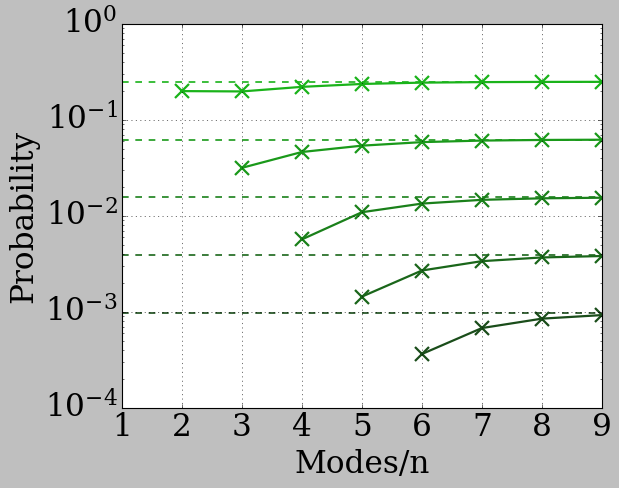

In [3]:
# plot

nmodes = []
total_deps_prob = []
ndeps_prob = []

with open("data/distribution.csv") as log:
    for line in log.readlines():
        line = line.strip()
        if len(line) == 0:
            continue

        nmodes_, deps_, *probs_ = map(float, line.split(' '))
        nmodes.append(nmodes_)
        total_deps_prob.append(deps_)
        ndeps_prob.append(probs_)

plt.clf()
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.15)
for n, data in enumerate(zip(*ndeps_prob)):
    n = n + 1
    plt_color = (0.1, 0.8 - n / (len(ndeps_prob[0]) + 5), 0.1)

    def filter_indices(predicate, iterable):
        datas = []
        indices = []
        for id, item in enumerate(iterable):
            if predicate(item):
                datas.append(item)
                indices.append(id)
        return datas, indices

    def slice_out(iterable, indices):
        data = []
        for id in indices:
            data.append(iterable[id])
        return data

    data, indices = filter_indices(lambda x: x > 0, data)

    plt.plot(slice_out(nmodes, indices), data, marker="x", markerfacecolor='none', color=plt_color,
             markersize=12, linewidth=2, markeredgewidth=2)
    plt.plot(nmodes, [0.25 ** n for _ in range(len(nmodes))],
             color=plt_color, linestyle='--', linewidth=1.5)
    plt.annotate(
        f"$n={n}$", (9.7, data[-1] * 1.19), fontsize=32, color=plt_color)
plt.grid()
plt.yscale('log')
plt.xlabel("Modes/n")
plt.ylabel("Probability")
plt.show()

#### Experiment: Average Pauli weight per-Majorana operator (small scale)

In [2]:
# adjust this number if it takes too long
MAX_MODES = 8

from fermihedral import DescentSolver
from fermihedral.satutil import Kissat
from fermihedral.majorana import get_bk_weight

nmodes = []
avg_fh_weight = []
avg_bk_weight = []

for i in range(1, MAX_MODES + 1):
    solver = DescentSolver(i, independence=True, vacuum=False)
    _, weight = solver.solve(progress=True, solver_init=Kissat, solver_args=[10 * 60])
    nmodes.append(i)
    avg_fh_weight.append(weight / (2 * i))
    avg_bk_weight.append(get_bk_weight(i) / (2 * i))


> model summary: 1 modes, independence = True, vacuum state = False


0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00, 992.97it/s]


> model summary: 2 modes, independence = True, vacuum state = False                                        


100%|██████████| 6/6 [00:00<00:00, 974.14it/s]


> model summary: 3 modes, independence = True, vacuum state = False                                        


100%|██████████| 15/15 [00:00<00:00, 699.19it/s]

found 11 weight for 3 modes

> model summary: 4 modes, independence = True, vacuum state = False                                        


100%|██████████| 28/28 [00:00<00:00, 531.43it/s]


> model summary: 5 modes, independence = True, vacuum state = False                                        


100%|██████████| 45/45 [00:00<00:00, 423.41it/s]


found 22 weight for 5 modes

In [ ]:
# plot result

def log_regress(x, y):
    log_x = [log2(i) for i in x]
    a, b, _, _, _ = linregress(log_x, y)
    return a, b, [a * i + b for i in log_x]

plt.clf()
plt.figure(figsize=(7, 6))
plt.subplots_adjust(left=0.12, right=0.98, top=0.95, bottom=0.15)
plt.plot(nmodes[:MAX_MODES], avg_bk_weight[:MAX_MODES], label="Bravyi-Kitaev", marker="o", markerfacecolor='none', markeredgecolor='brown', color='brown', markersize=12, linewidth=2, markeredgewidth=2)
plt.plot(nmodes[:MAX_MODES], avg_fh_weight[:MAX_MODES], label="Full SAT", marker="x", markerfacecolor='none', markeredgecolor='blue', color='blue', markersize=12, linewidth=2, markeredgewidth=2)
bk_a, bk_b, bk_data = log_regress(nmodes[:MAX_MODES], avg_bk_weight[:MAX_MODES])
plt.plot(nmodes[:MAX_MODES], bk_data, label=f"{bk_a:.2f}log$_2$(N)+{bk_b:.2f}", color="brown", ls="--", linewidth=1)
fh_a, fh_b, fh_data = log_regress(nmodes[:MAX_MODES], avg_fh_weight[:MAX_MODES])
plt.plot(nmodes[:MAX_MODES], fh_data, label=f"{fh_a:.2f}log$_2$(N)+{fh_b:.2f}", color="blue", ls="--", linewidth=1)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0), ncol=1, fontsize=21)
plt.grid()
plt.ylim(0.5, 3.7)
plt.xlim(0.5, 8.5)
plt.yticks([1, 2, 3])
plt.xlabel("Modes/n")
plt.ylabel("Pauli Weight/n")
plt.show()

#### Experiment: Average Pauli weight per-Majorana operator (larger scale)

Note: this step may take extremely long time.

In [ ]:
MAX_MODES = 19

from fermihedral import DescentSolver
from fermihedral.satutil import Kissat
from fermihedral.majorana import get_bk_weight

nmodes = []
fh_weight = []
avg_fh_weight = []
avg_bk_weight = []

TIMEOUT = 72 * 60 * 60 # 3 Days, adjust this number based on your computer's performance

for i in range(1, MAX_MODES + 1):
    solver = DescentSolver(i, independence=False, vacuum=False)
    _, weight = solver.solve(progress=True, solver_init=Kissat, solver_args=[TIMEOUT])
    nmodes.append(i)
    fh_weight.append(weight)
    avg_fh_weight.append(weight / (2 * i))
    avg_bk_weight.append(get_bk_weight(i) / (2 * i))

In [ ]:
# plot

exp_n_modes = nmodes[8:]
exp_avg_bk_weight = avg_bk_weight[8:]
exp_avg_fermihedral_weight = avg_fh_weight[8:]

plt.clf()
plt.figure(figsize=(14, 6))
plt.subplots_adjust(left=0.07, right=0.98, top=0.95, bottom=0.15, wspace=0.27)

plt.subplot(1, 2, 1)
plt.plot(exp_n_modes, exp_avg_bk_weight, label="Bravyi-Kitaev",
         marker="o", markerfacecolor='none', markeredgecolor='brown', color='brown', markersize=12, markeredgewidth=2, linewidth=2)
plt.plot(exp_n_modes, exp_avg_fermihedral_weight,
         label="SAT w/o Alg.", marker="x", markerfacecolor='none', markeredgecolor='blue', color='blue', markersize=12, markeredgewidth=2, linewidth=2)
bk_a, bk_b, bk_data = log_regress(exp_n_modes, exp_avg_bk_weight)
plt.plot(exp_n_modes, bk_data, color="brown", ls="--", linewidth=1)
fh_a, fh_b, fh_data = log_regress(exp_n_modes, exp_avg_fermihedral_weight)
plt.plot(exp_n_modes, fh_data, color="blue", ls="--", linewidth=1)
plt.legend(loc="upper left", fontsize=23)
plt.grid()
plt.xlabel("Modes/n")
plt.ylabel("Pauli Weight/n")
plt.yticks([3.0, 4.0, 5.0])


plt.subplot(1, 2, 2)
improvement = [(exp_avg_bk_weight[i] - exp_avg_fermihedral_weight[i])
               * 100 / exp_avg_bk_weight[i] for i in range(len(exp_n_modes))]
avg_improvement = sum(improvement) / len(improvement)
plt.bar(exp_n_modes, improvement, color="white",
        edgecolor="black", linewidth=1.5)
plt.plot([8] + exp_n_modes + [20], [avg_improvement for _ in range(
    len(exp_n_modes) + 2)], color='brown', linewidth=3)
plt.grid()
plt.xlabel("Modes/n")
plt.ylabel("Improvement/%")
plt.yticks([5, 15, 25])
plt.show()